In [1]:
import os
os.chdir('../')
import jhutil; jhutil.jhprint(1111, )

1111 


In [2]:
import sys
sys.path.append("Marigold")


In [3]:
# 2. load data

import torch
from torchvision import transforms

data_path = "/data2/wlsgur4011/SparseDC/tmp/test_data.pt"
data = torch.load(data_path)

import jhutil; jhutil.jhprint(1111, data)
my_image_tensor = data['rgb'][0].cpu()
import jhutil; jhutil.jhprint(2222, my_image_tensor)
my_image = transforms.ToPILImage()(my_image_tensor)

1111  {
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 0.996] μ=0.481 σ=0.234 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 3.553] μ=0.013 σ=0.203 cuda:0",
    "gt": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.811, 3.593] μ=2.924 σ=0.405 cuda:0"
}
2222  "tensor[3, 228, 304] n=207936 (0.8Mb) x∈[0., 0.996] μ=0.481 σ=0.234"


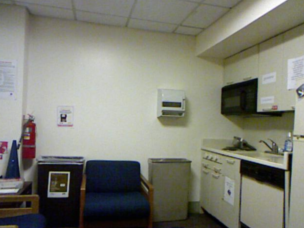

In [4]:
my_image

In [5]:

from marigold.marigold_pipeline import *

class MarigoldPipeline(DiffusionPipeline):
    """
    Args:
        unet (`UNet2DConditionModel`):
            Conditional U-Net to denoise the depth latent, conditioned on image latent.
        vae (`AutoencoderKL`):
            Variational Auto-Encoder (VAE) Model to encode and decode images and depth maps
            to and from latent representations.
        scheduler (`DDIMScheduler`):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents.
        text_encoder (`CLIPTextModel`):
            Text-encoder, for empty text embedding.
        tokenizer (`CLIPTokenizer`):
            CLIP tokenizer.
    """

    rgb_latent_scale_factor = 0.18215
    depth_latent_scale_factor = 0.18215

    def __init__(
        self,
        unet: UNet2DConditionModel,
        vae: AutoencoderKL,
        scheduler: DDIMScheduler,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
    ):
        super().__init__()

        self.register_modules(
            unet=unet,
            vae=vae,
            scheduler=scheduler,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
        )

        self.empty_text_embed = None

    @torch.no_grad()
    def __call__(
        self,
        input_image: Image,
        denoising_steps: int = 10,
        ensemble_size: int = 10,
        processing_res: int = 768,
        match_input_res: bool = True,
        batch_size: int = 0,
        color_map: str = "Spectral",
        show_progress_bar: bool = True,
        ensemble_kwargs: Dict = None,
    ) -> MarigoldDepthOutput:
        """
        Function invoked when calling the pipeline.

        Args:
            input_image (`Image`):
                Input RGB (or gray-scale) image.
            processing_res (`int`, *optional*, defaults to `768`):
                Maximum resolution of processing.
                If set to 0: will not resize at all.
            match_input_res (`bool`, *optional*, defaults to `True`):
                Resize depth prediction to match input resolution.
                Only valid if `limit_input_res` is not None.
            denoising_steps (`int`, *optional*, defaults to `10`):
                Number of diffusion denoising steps (DDIM) during inference.
            ensemble_size (`int`, *optional*, defaults to `10`):
                Number of predictions to be ensembled.
            batch_size (`int`, *optional*, defaults to `0`):
                Inference batch size, no bigger than `num_ensemble`.
                If set to 0, the script will automatically decide the proper batch size.
            show_progress_bar (`bool`, *optional*, defaults to `True`):
                Display a progress bar of diffusion denoising.
            color_map (`str`, *optional*, defaults to `"Spectral"`):
                Colormap used to colorize the depth map.
            ensemble_kwargs (`dict`, *optional*, defaults to `None`):
                Arguments for detailed ensembling settings.
        Returns:
            `MarigoldDepthOutput`: Output class for Marigold monocular depth prediction pipeline, including:
            - **depth_np** (`np.ndarray`) Predicted depth map, with depth values in the range of [0, 1]
            - **depth_colored** (`PIL.Image.Image`) Colorized depth map, with the shape of [3, H, W] and values in [0, 1]
            - **uncertainty** (`None` or `np.ndarray`) Uncalibrated uncertainty(MAD, median absolute deviation)
                    coming from ensembling. None if `ensemble_size = 1`
        """

        device = self.device
        input_size = input_image.size

        if not match_input_res:
            assert (
                processing_res is not None
            ), "Value error: `resize_output_back` is only valid with "
        assert processing_res >= 0
        assert denoising_steps >= 1
        assert ensemble_size >= 1

        # ----------------- Image Preprocess -----------------
        # Resize image
        if processing_res > 0:
            input_image = resize_max_res(
                input_image, max_edge_resolution=processing_res
            )
        # Convert the image to RGB, to 1.remove the alpha channel 2.convert B&W to 3-channel
        input_image = input_image.convert("RGB")
        image = np.asarray(input_image)

        # Normalize rgb values
        rgb = np.transpose(image, (2, 0, 1))  # [H, W, rgb] -> [rgb, H, W]
        rgb_norm = rgb / 255.0
        rgb_norm = torch.from_numpy(rgb_norm).to(self.dtype)
        rgb_norm = rgb_norm.to(device)
        assert rgb_norm.min() >= 0.0 and rgb_norm.max() <= 1.0

        # ----------------- Predicting depth -----------------
        # Batch repeated input image
        duplicated_rgb = torch.stack([rgb_norm] * ensemble_size)
        single_rgb_dataset = TensorDataset(duplicated_rgb)
        if batch_size > 0:
            _bs = batch_size
        else:
            _bs = find_batch_size(
                ensemble_size=ensemble_size,
                input_res=max(rgb_norm.shape[1:]),
                dtype=self.dtype,
            )

        single_rgb_loader = DataLoader(
            single_rgb_dataset, batch_size=_bs, shuffle=False
        )

        # Predict depth maps (batched)
        depth_pred_ls = []
        if show_progress_bar:
            iterable = tqdm(
                single_rgb_loader, desc=" " * 2 + "Inference batches", leave=False
            )
        else:
            iterable = single_rgb_loader
        for batch in iterable:
            (batched_img,) = batch
            depth_pred_raw = self.single_infer(
                rgb_in=batched_img,
                num_inference_steps=denoising_steps,
                show_pbar=show_progress_bar,
            )
            depth_pred_ls.append(depth_pred_raw.detach().clone())
        depth_preds = torch.concat(depth_pred_ls, axis=0).squeeze()
        torch.cuda.empty_cache()  # clear vram cache for ensembling

        # ----------------- Test-time ensembling -----------------
        if ensemble_size > 1:
            depth_pred, pred_uncert = ensemble_depths(
                depth_preds, **(ensemble_kwargs or {})
            )
        else:
            depth_pred = depth_preds
            pred_uncert = None

        # ----------------- Post processing -----------------
        # Scale prediction to [0, 1]
        min_d = torch.min(depth_pred)
        max_d = torch.max(depth_pred)
        depth_pred = (depth_pred - min_d) / (max_d - min_d)

        # Convert to numpy
        depth_pred = depth_pred.cpu().numpy().astype(np.float32)

        # Resize back to original resolution
        if match_input_res:
            pred_img = Image.fromarray(depth_pred)
            pred_img = pred_img.resize(input_size)
            depth_pred = np.asarray(pred_img)

        # Clip output range
        depth_pred = depth_pred.clip(0, 1)

        # Colorize
        depth_colored = colorize_depth_maps(
            depth_pred, 0, 1, cmap=color_map
        ).squeeze()  # [3, H, W], value in (0, 1)
        depth_colored = (depth_colored * 255).astype(np.uint8)
        depth_colored_hwc = chw2hwc(depth_colored)
        depth_colored_img = Image.fromarray(depth_colored_hwc)
        return MarigoldDepthOutput(
            depth_np=depth_pred,
            depth_colored=depth_colored_img,
            uncertainty=pred_uncert,
        )

    def __encode_empty_text(self):
        """
        Encode text embedding for empty prompt
        """
        prompt = ""
        text_inputs = self.tokenizer(
            prompt,
            padding="do_not_pad",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids.to(self.text_encoder.device)
        self.empty_text_embed = self.text_encoder(text_input_ids)[0].to(self.dtype)

    @torch.no_grad()
    def single_infer(
        self, rgb_in: torch.Tensor, num_inference_steps: int, show_pbar: bool
    ) -> torch.Tensor:
        """
        Perform an individual depth prediction without ensembling.

        Args:
            rgb_in (`torch.Tensor`):
                Input RGB image.
            num_inference_steps (`int`):
                Number of diffusion denoisign steps (DDIM) during inference.
            show_pbar (`bool`):
                Display a progress bar of diffusion denoising.
        Returns:
            `torch.Tensor`: Predicted depth map.
        """
        device = rgb_in.device

        # Set timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps  # [T]

        # Encode image
        rgb_latent = self.encode_rgb(rgb_in)

        # Initial depth map (noise)
        depth_latent = torch.randn(
            rgb_latent.shape, device=device, dtype=self.dtype
        )  # [B, 4, h, w]

        # Batched empty text embedding
        if self.empty_text_embed is None:
            self.__encode_empty_text()
        batch_empty_text_embed = self.empty_text_embed.repeat(
            (rgb_latent.shape[0], 1, 1)
        )  # [B, 2, 1024]

        # Denoising loop
        if show_pbar:
            iterable = tqdm(
                enumerate(timesteps),
                total=len(timesteps),
                leave=False,
                desc=" " * 4 + "Diffusion denoising",
            )
        else:
            iterable = enumerate(timesteps)

        for i, t in iterable:
            unet_input = torch.cat(
                [rgb_latent, depth_latent], dim=1
            )  # this order is important

            # predict the noise residual
            noise_pred = self.unet(
                unet_input, t, encoder_hidden_states=batch_empty_text_embed
            ).sample  # [B, 4, h, w]

            # compute the previous noisy sample x_t -> x_t-1
            depth_latent = self.scheduler.step(noise_pred, t, depth_latent).prev_sample
        torch.cuda.empty_cache()
        depth = self.decode_depth(depth_latent)

        # clip prediction
        depth = torch.clip(depth, -1.0, 1.0)
        # shift to [0, 1]
        depth = (depth + 1.0) / 2.0

        return depth

    def encode_rgb(self, rgb_in: torch.Tensor) -> torch.Tensor:
        """
        Encode RGB image into latent.

        Args:
            rgb_in (`torch.Tensor`):
                Input RGB image to be encoded.

        Returns:
            `torch.Tensor`: Image latent.
        """
        # encode
        h = self.vae.encoder(rgb_in)
        moments = self.vae.quant_conv(h)
        mean, logvar = torch.chunk(moments, 2, dim=1)
        # scale latent
        rgb_latent = mean * self.rgb_latent_scale_factor
        return rgb_latent

    def decode_depth(self, depth_latent: torch.Tensor) -> torch.Tensor:
        """
        Decode depth latent into depth map.

        Args:
            depth_latent (`torch.Tensor`):
                Depth latent to be decoded.

        Returns:
            `torch.Tensor`: Decoded depth map.
        """
        # scale latent
        depth_latent = depth_latent / self.depth_latent_scale_factor
        # decode
        z = self.vae.post_quant_conv(depth_latent)
        stacked = self.vae.decoder(z)
        # mean of output channels
        depth_mean = stacked.mean(dim=1, keepdim=True)
        return depth_mean


In [6]:
# 3. run model
import argparse
import os
from glob import glob
import logging

import numpy as np
import torch

from torchvision import transforms
from marigold import MarigoldPipeline
from marigold.util.seed_all import seed_all


def init_marigold(checkpoint_path="Bingxin/Marigold",
                  half_precision=False,
                  apple_silicon=False,
                  seed=1234):
    
    if seed is None:
        import time
        seed = int(time.time())
    seed_all(seed)
    
    if apple_silicon:
        if torch.backends.mps.is_available() and torch.backends.mps.is_built():
            device = torch.device("mps:0")
        else:
            device = torch.device("cpu")
            logging.warning("MPS is not available. Running on CPU will be slow.")
    else:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
            logging.warning("CUDA is not available. Running on CPU will be slow.")
    
    if half_precision:
        dtype = torch.float16
        logging.info(f"Running with half precision ({dtype}).")
    else:
        dtype = torch.float32
    
    pipe = MarigoldPipeline.from_pretrained(checkpoint_path, torch_dtype=dtype)
    
    try:
        import xformers

        pipe.enable_xformers_memory_efficient_attention()
    except:
        pass  # run without xformers

    pipe = pipe.to(device)
    return pipe
    


@torch.no_grad()
def run_marigold(pipe, image,
                 denoise_steps=10,
                 ensemble_size=10,
                 processing_res=768,
                 match_input_res=True,
                 batch_size=0,
                 color_map="Spectral",
                 device="cuda"):


    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image.cpu())
        
    # Predict depth
    pipe_out = pipe(
        image,
        denoising_steps=denoise_steps,
        ensemble_size=ensemble_size,
        processing_res=processing_res,
        match_input_res=match_input_res,
        batch_size=batch_size,
        color_map=color_map,
        show_progress_bar=False,
    )

    depth_pred: np.ndarray = pipe_out.depth_np
    depth_pred = torch.from_numpy(depth_pred).to(device)
    return depth_pred

marigold = init_marigold()
depth = run_marigold(marigold, my_image)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

1111  "tensor[1, 228, 304] n=69312 (0.3Mb) x∈[0.005, 1.000] μ=0.623 σ=0.217 cuda:0"


/tmp/ipykernel_13699/3972397139.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  depth = torch.tensor(depth)[None, :].cuda()


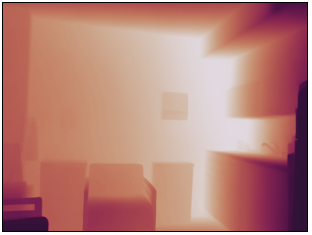

In [7]:
# 4. show depth
depth = torch.tensor(depth)[None, :].cuda()
import jhutil; jhutil.jhprint(1111, depth)
depth.chans

In [8]:
torch.save(depth, "tmp/depthmap.pt")

1111  "tensor[1, 228, 304] n=69312 (0.3Mb) x∈[1.811, 3.593] μ=2.924 σ=0.405 cuda:0"


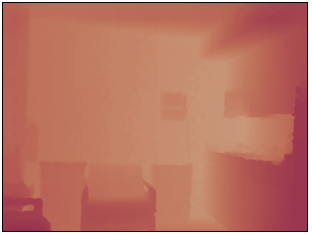

In [9]:
# 5. gt depth
gt_depth = data['gt'][0]
import jhutil; jhutil.jhprint(1111, gt_depth)
(gt_depth / 5).chans

1111  "tensor[1, 228, 304] bool n=69312 (68Kb) x∈[False, True] μ=0.004 σ=0.065 cuda:0"


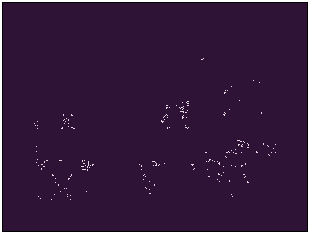

In [10]:
mask = data['dep'][0] != 0
import jhutil; jhutil.jhprint(1111, mask)
mask.chans

In [11]:
# copy from MiDaS
def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


In [12]:
scale, shift = compute_scale_and_shift(depth, gt_depth, mask)
depth = scale.view(-1, 1, 1) * depth + shift.view(-1, 1, 1)


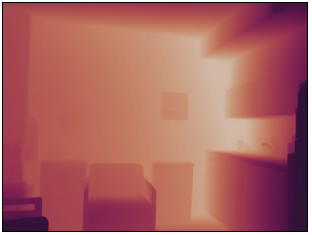

In [13]:
((depth - depth.min()) / 2).chans

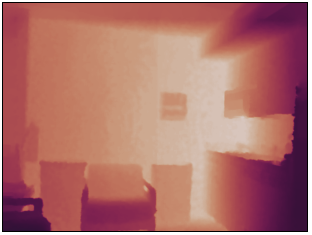

In [14]:
((gt_depth - gt_depth.min()) / 2).chans

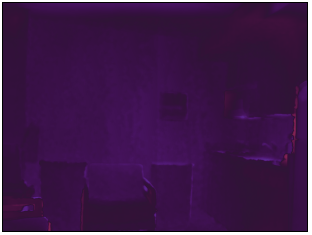

In [16]:
(((depth - depth.min()) / 2) - (gt_depth - gt_depth.min()) / 2).chans

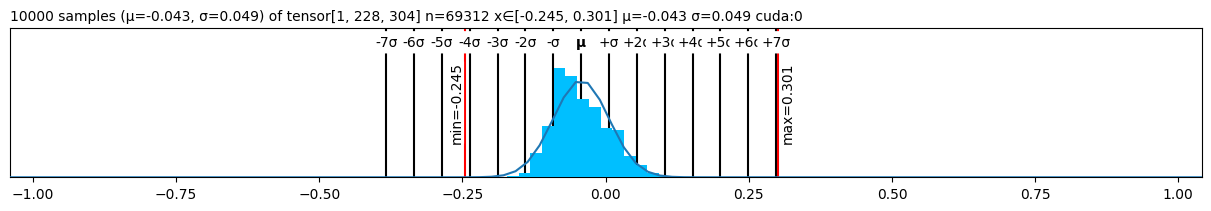

In [17]:
(((depth - depth.min()) / 2) - (gt_depth - gt_depth.min()) / 2).plt